# Lab: Bedrock model integration with Langchain Agents

In this notebook, you learn how to use a plan-and-execute agent that determines the order of actions and implements them using the tools available to the agents.

Certain applications demand an adaptable sequence of calls to the language models and various utilities to answer a user's question. The Langchain Agent interface is flexible and can integrate external tools with LLM's reasoning. Agents can select the tool to use based on the user input. Agents are capable of using multiple tools and utilizing the output of one tool as the input for the next.

## Scenario:

Imagine you are building a customer support system for an e-commerce platform. Users ask questions about product pricing and availability, and the system needs to intelligently respond using a combination of internal data (such as sales information from a CSV file) and external APIs or services. The system should reason step-by-step to gather all necessary data before presenting a final answer.

**For example, a user might ask:**

"How much will it cost to buy 3 units of P002 and 5 units of P003?"

The system should query a CSV database, calculate the total cost, and respond accordingly.

Additionally, the system should be able to handle complex queries that involve calculations, using an in-built calculator tool to perform necessary operations. By integrating Amazon Bedrock models with Langchain agents, the system can dynamically select and execute the appropriate tools based on user input, providing an intelligent, seamless interaction.

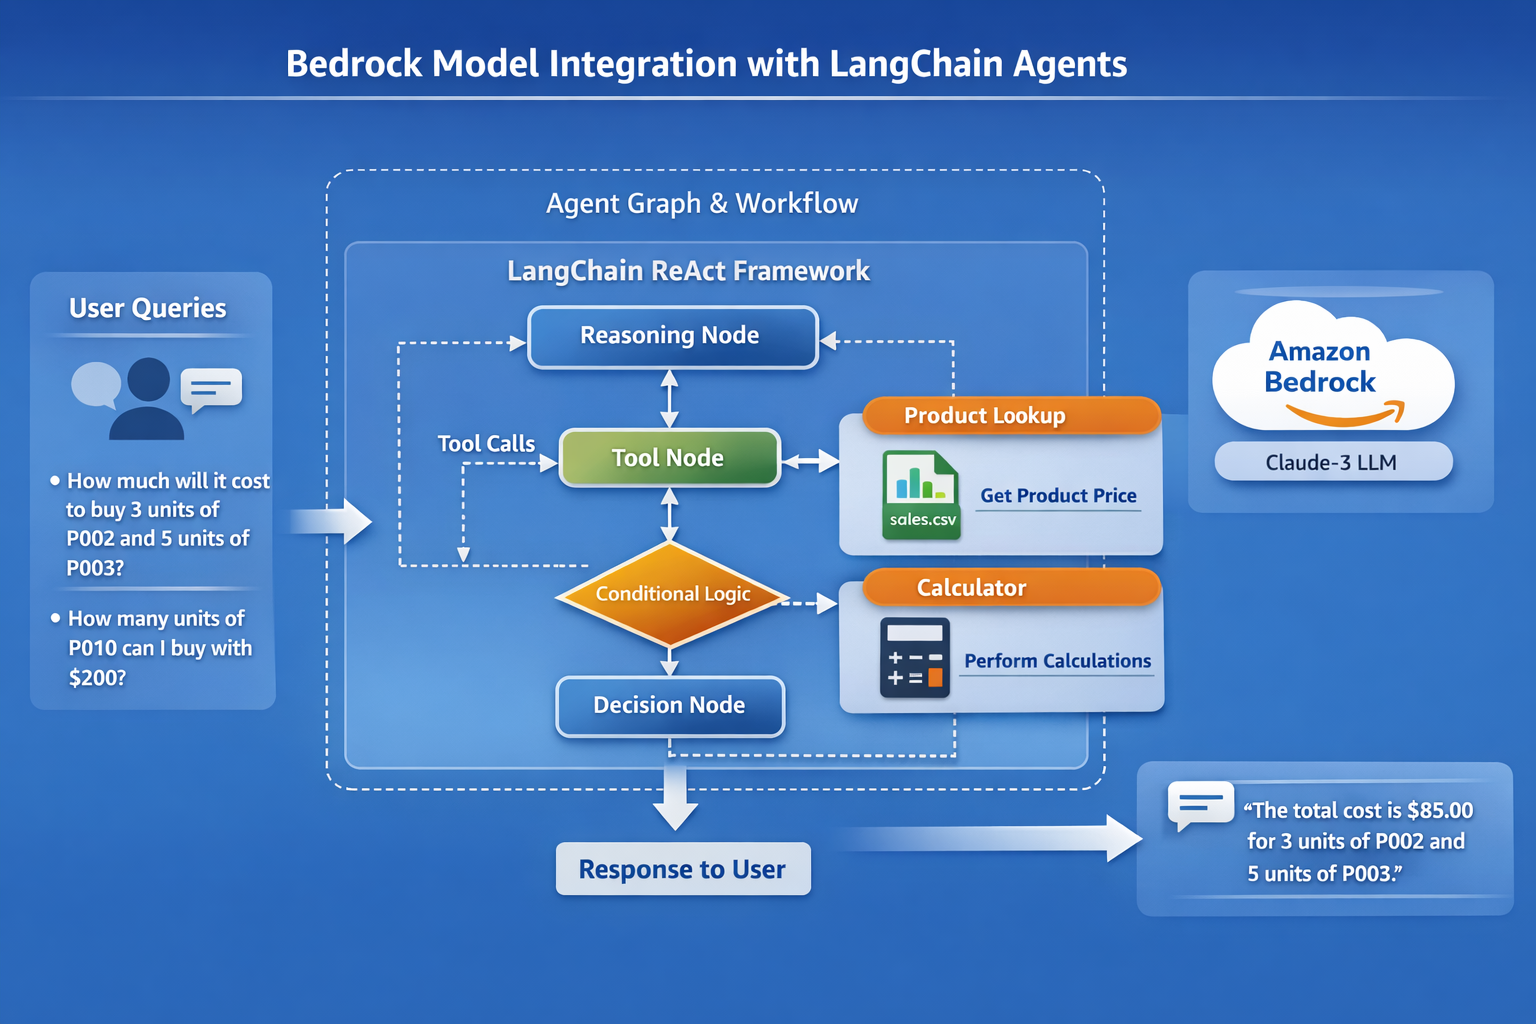

### Step 1: Environment setup

In this task, we sets up everything necessary to connect your Python code with AWS, making sure that the libraries are installed, AWS credentials are configured, and the correct region is selected.

Without this setup, the system wouldn't be able to access and interact with the AWS services needed for the tasks.

In [ ]:
# Importing necessary Python libraries and modules

import math  # Importing the math library for mathematical functions
import numexpr  # Importing numexpr to efficiently evaluate mathematical expressions
import json  # Importing json to handle JSON data (often used in APIs)
import datetime  # Importing datetime to work with date and time
import sys  # Importing sys for system-specific parameters and functions
import os  # Importing os to interact with the operating system (e.g., file paths)

# Importing the Boto3 library, which is the AWS SDK for Python
import boto3  # Boto3 allows Python code to interact with AWS services, including AI models on Bedrock

# Installing the required libraries via pip
# These commands install or update LangChain's AWS-specific modules and other dependencies

%pip install -U langchain-aws boto3  # Install or update the AWS-specific LangChain library and Boto3 (AWS SDK for Python)
%pip install -U langgraph  # Install or update the LangGraph library for creating graph-based workflows

# Adding the parent directory to the system path so we can import modules from it
module_path = ".."  # The parent directory
sys.path.append(os.path.abspath(module_path))  # Adds the parent directory to the path, making it accessible for imports

# Setting up the Bedrock client using Boto3 to interact with AWS Bedrock services
# 'bedrock-runtime' is the service for interacting with AI models hosted on Amazon Bedrock
bedrock_client = boto3.client('bedrock-runtime', region_name=os.environ.get("AWS_DEFAULT_REGION", None))
# 'model_id' refers to the specific AI model from Amazon Bedrock that will be used (Claude-3 in this case)
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"


Next, you create an instance of LangChain's ChatBedrock class, which allows you to interact with a conversational AI model hosted on Amazon Bedrock

In [ ]:
# Import the ChatBedrock class from the langchain_aws module
# This class allows us to interact with the AI model hosted on Amazon Bedrock
from langchain_aws import ChatBedrock

# Create an instance of the ChatBedrock class
# 'model_id' is the ID of the specific AI model you want to use (in this case, Claude-3 from Amazon Bedrock)
# 'bedrock_client' is the client we created earlier to connect to the AWS Bedrock service
chat_model = ChatBedrock(
    model_id=model_id,  # The model ID we want to interact with (Claude-3)
    client=bedrock_client  # The AWS Bedrock client to authenticate and connect to the service
)


#### Comments Breakdown:

1. **`from langchain_aws import ChatBedrock`:**
   - This imports the `ChatBedrock` class from the `langchain_aws` library, which is specifically designed to allow communication with Amazon's Bedrock service. This class makes it easier to interact with language models hosted on AWS Bedrock.

2. **`chat_model = ChatBedrock(...)`:**
   - This line creates an instance (or object) of the `ChatBedrock` class, which allows you to interact with the specified AI model.

3. **`model_id=model_id`:**
   - You specify the model ID (in this case, `Claude-3`), which tells the system which specific AI model you want to use.

4. **`client=bedrock_client`:**
   - You pass the previously created AWS Bedrock client (`bedrock_client`) so the `ChatBedrock` instance can connect to AWS and authenticate requests.

By the end of this step, you have an object (`chat_model`) that is ready to interact with the **Claude-3** AI model on Amazon Bedrock.


In [ ]:
# Invoke the model using the 'invoke' method of the 'chat_model' object

# This sends a query to the Claude-3 model and receives a response

# In this case, we are asking "What is AWS?" and requesting that the answer be provided in a single sentence
chat_model.invoke("what is AWS? Answer in a single sentence")


#### Code Breakdown:

 **`chat_model.invoke("what is AWS? Answer in a single sentence")`:**

   - This line calls the `invoke()` method of the `chat_model` object.
   - **`chat_model`**: This is the instance of the `ChatBedrock` class, which connects to the Amazon Bedrock model.

   - **`invoke()`**: This method sends a prompt (question) to the language model (Claude-3 in this case) and requests a response.

   - The prompt is: `"what is AWS? Answer in a single sentence"`, asking the model to provide a brief explanation of AWS.

   - The model will process the query and generate a response, which will be returned to the caller.


By using this `invoke()` method, you're able to query the Claude-3 AI model hosted on Amazon Bedrock and get responses to various questions or tasks you send to it.


### Step 2: Synergizing Reasoning and Acting in Language Models Framework

In this task, the ReAct framework enables large language models to interact with external tools to obtain additional information that results in more accurate and fact-based responses.

Large language models can generate both explanations for their reasoning and task-specific responses in an alternating fashion.

Producing reasoning explanations enables the models to infer, monitor, and revise action plans, and even handle unexpected scenarios. The action step allows the models to interface with and obtain information from external sources such as knowledge bases or environments.

In [ ]:
# Importing the 'tool'

# The 'tool' decorator is used to define functions as tools that can be used by LangChain agents
# These tools can be invoked by the agents to perform specific actions like querying a database or performing calculations
from langchain_core.tools import tool


#### Code Breakdown:

1. **`from langchain_core.tools import tool`**:
   - This line imports the `tool` decorator from the `langchain_core.tools` module.
   - **`tool`**: The `tool` decorator is used to define a function as a "tool" that can be used by **LangChain agents**.
   - In LangChain, agents are able to interact with external functions or services (like APIs, databases, or calculations). By using the `tool` decorator, you enable these functions to be available to the agents.
   
   For example, you can define a function like `get_product_price` as a tool using the `@tool` decorator. Then, LangChain agents can invoke that function to retrieve data or perform an action as part of their reasoning process.


The `tool` decorator is crucial for allowing LangChain agents to access and use external functions that provide necessary functionality in building intelligent systems. It marks functions as available tools in the agent's toolkit.


In [ ]:
import csv

# Data to be written to the CSV file (example)
products = [
    {"product_id": "P001", "price": "10.00"},
    {"product_id": "P002", "price": "15.50"},
    {"product_id": "P003", "price": "20.00"}
]

# Open or create the sales.csv file
with open('sales.csv', 'w', newline='') as file:
    # Define the column names
    fieldnames = ['product_id', 'price']

    # Create a CSV dict writer object
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header (column names)
    writer.writeheader()

    # Write the product data
    writer.writerows(products)

# Confirm the file is created
print("sales.csv file created successfully!")


#### Code Breakdown:

1. **`import csv`**: Imports the `csv` module to handle CSV files.
2. **`products = [...]`**: Defines a list of products with their IDs and prices.
3. **`open('sales.csv', 'w', newline='')`**: Opens (or creates) the `sales.csv` file in write mode.
4. **`csv.DictWriter(file, fieldnames=fieldnames)`**: Prepares to write data as dictionaries to the CSV.
5. **`writer.writeheader()`**: Writes the column headers to the CSV.
6. **`writer.writerows(products)`**: Writes the product data rows to the CSV.
7. **`print("sales.csv file created successfully!")`**: Prints a confirmation message.

This code creates a `sales.csv` file with product data (ID and price).


In [ ]:
# The @tool decorator marks this function as a tool that can be invoked by LangChain agents
@tool
def get_product_price(query: str):
    """
    This function looks up the price of a product from the 'sales.csv' file.

    Args:
    - query (str): The product ID for which the price is being requested.

    Returns:
    - str: The price of the requested product or a message if the product is not found.
    """
    import csv  # Importing the CSV module to read the CSV file

    prices = {}  # Initialize an empty dictionary to store product prices

    # Attempt to open the 'sales.csv' file to read product data
    try:
        file = open('sales.csv', 'r')  # Open the file in read mode
    except Exception as e:
        # If an error occurs while opening the file, return a failure message
        return ("Unable to look up the price for " + query)

    # Read the CSV file and store the data in a dictionary with product_id as the key and price as the value
    reader = csv.DictReader(file)  # Read the CSV as a dictionary
    for row in reader:
        prices[row['product_id']] = row['price']  # Store product ID and price in the dictionary

    file.close()  # Close the file after reading the data

    # Extract the product ID from the user query
    qstr = query.split("\n")[0].strip()  # Take the first line of the query and remove extra spaces

    try:
        # Look up the price in the dictionary and return the result
        return ("Price of product " + qstr + " is " + prices.get(qstr) + "\n")
    except:
        # If the product is not found in the dictionary, return an error message
        return ("Price for product " + qstr + " is not available" + "\n")


In the next cell, you define a function `get_product_price` that serves as a tool within the Langchain framework and retrieves the price of the product specified in the query from `sales.csv` file created from previous task. It is a simple implementation to illustrate how tools can be designed to work with the Langchain framework.

#### Code Breakdown:

1. **`@tool` decorator**:
   - The `@tool` decorator marks the `get_product_price` function as a **tool** that can be invoked by **LangChain agents**. This allows LangChain agents to use this function to get product prices as part of their reasoning and action process.

2. **Function `get_product_price(query: str)`**:
   - This function takes a `query` as input, which should be a string containing the product ID for which the price is being requested.
   
3. **CSV Handling**:
   - The function opens the `sales.csv` file and reads the product data using Python's **csv.DictReader** to handle the data as key-value pairs (product_id -> price).
   
4. **Error Handling**:
   - If the file cannot be opened, the function returns a message saying it cannot look up the price.
   - If the product ID is not found in the CSV, the function returns a message indicating that the price for the product is not available.
   
5. **Return Output**:
   - The function returns a string with the product's price if it is found in the CSV file, or a message stating that the price is unavailable if the product ID is not found.


This function is a useful tool in LangChain that allows an agent to query product prices from a CSV file, perform error handling, and return useful results.


In the next cell, you define a function `calculator` that serves as a tool within the Langchain framework. This tool enables a language model to perform mathematical calculations by evaluating a given expression using Python's numexpr library. The tool is designed to handle cases where the expression is invalid. In that case, the tool aks the model to rethink its approach to the calculation.

In [ ]:
# The @tool decorator marks this function as a tool that can be invoked by LangChain agents

# This function solves mathematical expressions passed as a string, such as "5*4" or "10/2"

@tool
def calculator(expression: str) -> str:
    """
    Use this tool to solve math problems that involve a single-line mathematical expression.
    The expression should use math notation (e.g., "5*4" for multiplication, "5/4" for division).

    Examples:
        - "5*4" for "5 times 4"
        - "5/4" for "5 divided by 4"
    """
    try:
        # The numexpr.evaluate function is used to evaluate the mathematical expression efficiently.
        # It parses and computes the result of the expression in the string.
        return str(
            numexpr.evaluate(
                expression.strip(),  # Remove leading/trailing spaces from the expression
                global_dict={},  # Can be used to pass global math constants (left empty here)
                local_dict={}  # Can be used to pass local variables or constants (left empty here)
            )
        )
    except Exception as e:
        # If the expression cannot be evaluated (e.g., due to invalid syntax), return an error message.
        return "Rethink your approach to this calculation"


#### Code Breakdown:

1. **`@tool` decorator**:
   - The `@tool` decorator marks the `calculator` function as a **tool** that can be used by **LangChain agents**. This makes it available for use when the agent encounters a mathematical expression that needs to be evaluated.

2. **Function `calculator(expression: str)`**:
   - This function takes a mathematical expression as input in the form of a string (e.g., "5*4", "10/2").
   
3. **Expression Evaluation**:
   - **`numexpr.evaluate(expression.strip(), ...)`**:
     - This line uses the **numexpr** library to efficiently evaluate the mathematical expression.
     - The `strip()` function removes any extra spaces from the expression.
     - `numexpr.evaluate()` processes the expression and computes the result.
     - `global_dict` and `local_dict` can be used to pass constants or variables if needed, but they are left empty here.

4. **Error Handling**:
   - If the expression is invalid (e.g., contains syntax errors), the function catches the exception and returns the message: `"Rethink your approach to this calculation"`.

5. **Return Output**:
   - If the evaluation is successful, the function returns the result of the calculation as a string.
   - If the calculation cannot be done due to an error, it returns an error message prompting the user to rethink the expression.


This function is a tool within LangChain that allows an agent to solve mathematical expressions, making it useful for agents that need to handle calculations as part of their tasks.


In [ ]:
# Create a list of tools that can be used by LangChain agents

# The tools list contains the functions that the agent can call to perform specific actions

tools = [get_product_price, calculator]


#### Code Breakdown:

1. **`tools = [get_product_price, calculator]`**:
   - This line defines a list named **`tools`** that contains the functions **`get_product_price`** and **`calculator`**.
   - The **`tools`** list allows LangChain agents to access and invoke these functions (tools) during their reasoning and action process.
   
2. **`get_product_price`**:
   - This function, defined earlier, looks up the price of a product based on a query. It interacts with a CSV file to retrieve the product price.

3. **`calculator`**:
   - This function evaluates mathematical expressions, such as "5*4" or "10/2", using the **numexpr** library for efficient computation.


The **tools list** acts as a collection of callable functions that LangChain agents can use when they need to perform tasks like querying a product's price or solving a math problem. The agent can dynamically select and invoke one of these tools based on the user input.


In the next cell, you run helper functions to print trace output to a file

In [ ]:
# Import necessary classes for handling different types of messages in LangChain
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage

# Define a function to output the trace information during the execution of the agent
# This function helps in debugging by logging the trace of the agent's reasoning and actions
def output_trace(element: str, trace, node=True):
    global trace_handle  # Declare the trace_handle as global to modify it within the function

    # Check if trace is enabled to print the trace output
    if trace_enabled:
        # Print the current timestamp to the trace file
        print(datetime.datetime.now(), file=trace_handle)

        # Print whether the current element is a node or an edge in the trace
        print(("Node: " if node else "Edge: ") + element, file=trace_handle)

        # If the element is "ask_model_to_reason (entry)", it means the reasoning process is starting,
        # so we print the trace information for each single trace.
        if element == "ask_model_to_reason (entry)":
            for single_trace in trace:
                print(single_trace, file=trace_handle)
        else:
            # Otherwise, print the trace information as it is
            print(trace, file=trace_handle)

        # Print a separator to clearly separate each trace entry in the trace file
        print('----', file=trace_handle)

# Define a function to filter and return only ToolMessage objects from the message list
# ToolMessage objects represent messages exchanged between the agent and external tools
def consolidate_tool_messages(message):
    tool_messages = []  # Initialize an empty list to store ToolMessage objects

    # Loop through the messages and add only ToolMessage objects to the tool_messages list
    for msg in message:
        if isinstance(msg, ToolMessage):  # Check if the message is an instance of ToolMessage
            tool_messages.append(msg)  # Add the ToolMessage to the list

    # Return the list of ToolMessages
    return tool_messages


#### Code Breakdown:

1. **`from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage`**:
   - This line imports the necessary classes for handling different types of messages in LangChain.
   - **HumanMessage**: Represents a message from a human user.
   - **SystemMessage**: Represents a system-generated message.
   - **AIMessage**: Represents a message generated by the AI model.
   - **ToolMessage**: Represents a message that is generated when a tool is used by the agent.

2. **`output_trace(element: str, trace, node=True)`**:
   - This function outputs the trace information for debugging purposes during the execution of LangChain agents.
   - **`element`**: The current element in the trace (could be a node or edge).
   - **`trace`**: The trace data that represents the reasoning or actions of the agent.
   - **`node`**: A flag to distinguish between nodes and edges in the trace graph.
   - **`trace_enabled`**: A flag to control whether trace output is enabled. If `True`, the trace information is logged.
   - **`trace_handle`**: A file handle used to write the trace data to a log file.

3. **`consolidate_tool_messages(message)`**:
   - This function filters out only the **ToolMessage** objects from a list of messages.
   - **ToolMessage** objects represent messages exchanged between the agent and external tools, like databases or calculators.
   - The function loops through the messages, checks if each message is a **ToolMessage**, and adds it to the `tool_messages` list.
   - It then returns a list of all **ToolMessage** objects found in the input message list.


The `output_trace` function helps in logging and debugging the reasoning steps of the LangChain agent, while the `consolidate_tool_messages` function filters and returns messages related to tool usage, which is useful for tracking agent interactions with external tools.


### Step 3: Building an Agent Graph

In this task, you will be creating an agent graph for a conversational AI system that can interact with external tools. The agent graph is a state machine that defines the flow of the conversation and the interaction with the tools.

In the next cell, you define nodes with associated functions that update the state based on input. Connect nodes using edges, where the graph transitions from one node to the next. Incorporate conditional edges to route the graph to different nodes based on specific conditions. Finally, compile the agent graph to prepare it for execution, handling transitions and state updates as defined.


In [ ]:
# Import necessary components for building the state graph
from typing import Literal  # Importing Literal to specify possible return types in the function
from langgraph.graph import StateGraph, MessagesState  # Importing StateGraph and MessagesState for graph creation
from langgraph.prebuilt import ToolNode  # Importing ToolNode, a prebuilt component for handling tools in the graph

# ToolNode is a prebuilt component that runs the tool and appends the tool result to the messages
# The 'tools' list contains the available tools (e.g., get_product_price, calculator)
tool_node = ToolNode(tools)

# Bind the tools to the model so that the model knows which tools it can access during execution
model_with_tools = chat_model.bind_tools(tools)

# Define a function for the conditional edge in the agent graph. This function decides the next step based on the messages.
# It checks if the agent's last message includes a tool call. If so, it proceeds to the "tools" node; otherwise, it ends the chain.
def next_step(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]  # Get the last message in the conversation history
    if last_message.tool_calls:
        # If the message includes tool calls, proceed to the "tools" node
        output_trace("next_step: Proceed to tools", last_message, node=False)
        return "tools"
    # Otherwise, end the chain
    output_trace("next_step: Proceed to end", last_message, node=False)
    return "__end__"

# Define the node function that invokes the model to process the messages
# The model will use the tools and reasoning capabilities to generate a response.
def ask_model_to_reason(state: MessagesState):
    messages = state["messages"]
    # Output trace information for debugging
    output_trace("ask_model_to_reason (entry)", consolidate_tool_messages(messages))
    try:
        # Try invoking the model with the available tools and messages
        response = model_with_tools.invoke(messages)
    except Exception as e:
        # If an error occurs, log the exception and return an error message
        output_trace("ask_model_to_reason", messages)
        output_trace("ask_model_to_reason", "Exception: " + str(e))
        return {"messages": [messages.append("Unable to invoke the model")]}  # Append error message to messages
    # Output the response trace and return the generated response
    output_trace("ask_model_to_reason (exit)", response)
    return {"messages": [response]}

# Initialize a StateGraph instance with MessagesState, which represents the state of the conversation
agent_graph = StateGraph(MessagesState)

# Add the nodes to the graph. Each node is associated with a function that will be executed when the node is reached.
agent_graph.add_node("agent", ask_model_to_reason)  # The "agent" node invokes the model to reason
agent_graph.add_node("tools", tool_node)  # The "tools" node invokes the tool(s)

# Define the edges (connections) between the nodes in the graph.
# The agent node is the first to be reached from the entry node.
agent_graph.add_edge("__start__", "agent")

# After the "tools" node is processed, the graph transitions back to the "agent" node
agent_graph.add_edge("tools", "agent")

# The transition from the "agent" node is conditional.
# If the agent's response includes tool calls, the graph moves to the "tools" node; otherwise, it ends.
agent_graph.add_conditional_edges("agent", next_step)

# Compile the graph definition, which prepares it for execution
react_agent = agent_graph.compile()


#### Code Breakdown:

1. **`from typing import Literal`**:
   - This line imports `Literal`, which is used to specify that a function will return one of the predefined literal values (in this case, `"tools"` or `"__end__"`).

2. **`from langgraph.graph import StateGraph, MessagesState`**:
   - **`StateGraph`**: A class used to create a directed graph representing the state of an agent's process.
   - **`MessagesState`**: Represents the state of the messages in the conversation, which can be passed between the nodes in the graph.

3. **`from langgraph.prebuilt import ToolNode`**:
   - **`ToolNode`**: A pre-built component that runs the tool(s) and appends the results to the conversation messages. It is added to the agent graph to represent a node that interacts with external tools.

4. **`tool_node = ToolNode(tools)`**:
   - **`ToolNode`** is created using the **`tools`** list, which contains the functions that the LangChain agent can use to perform tasks (e.g., `get_product_price` and `calculator`).

5. **`model_with_tools = chat_model.bind_tools(tools)`**:
   - This line binds the tools to the **`chat_model`**, allowing the model to know which tools it can use during reasoning and decision-making.

6. **`next_step(state: MessagesState)`**:
   - This function is responsible for determining the next step in the agent graph. If the agent's last message includes tool calls, it transitions to the "tools" node. Otherwise, it ends the conversation flow.

7. **`ask_model_to_reason(state: MessagesState)`**:
   - This node function invokes the model (which has access to the tools) to process the conversation and provide a response. It also handles exceptions and logs trace information for debugging.

8. **`agent_graph = StateGraph(MessagesState)`**:
   - Initializes a new **`StateGraph`**, which represents the conversation flow as a directed graph of nodes and edges.

9. **`agent_graph.add_node()`**:
   - Adds nodes to the graph. Each node is associated with a function (e.g., **`ask_model_to_reason`** or **`tool_node`**) that will be executed when the agent reaches that node.

10. **`agent_graph.add_edge()`**:
    - Defines the connections (edges) between the nodes, specifying how the graph should flow from one node to the next.

11. **`agent_graph.add_conditional_edges()`**:
    - Adds a conditional edge from the "agent" node. The transition is based on whether the model's response includes tool calls or not.

12. **`react_agent = agent_graph.compile()`**:
    - Compiles the graph, making it ready for execution. This prepares the agent's flow, allowing it to interact with the tools and reason about the next steps.


This code creates a **state machine** (graph) where each node represents an action or reasoning step, and the graph controls the agent's flow. By compiling the graph, the agent can dynamically decide whether to call a tool or finish the process, depending on the input and reasoning at each stage.


Next, you visualize the compiled graph. Observe the transition out of the agent node is conditional as indicated by the dotted line.

In [ ]:
# Import the necessary functions from IPython for displaying images in Jupyter/Colab notebooks
from IPython.display import Image, display

# Try to display the compiled agent graph as a PNG image using Mermaid syntax
try:
    # The get_graph() method generates a graph of the agent's flow, which is then drawn as a Mermaid diagram
    # The draw_mermaid_png() function converts the graph into a PNG image
    display(Image(react_agent.get_graph().draw_mermaid_png()))  # Display the PNG image in the notebook
except Exception:
    # If the required dependencies are not available (e.g., for rendering Mermaid diagrams), this block will silently pass
    # This step is optional and depends on whether the environment supports Mermaid graph rendering
    pass


#### Code Breakdown:

1. **`from IPython.display import Image, display`**:
   - **`Image`**: This function is used to display an image in Jupyter or Colab notebooks.
   - **`display`**: This function is used to display various objects (such as images, text, or plots) in the notebook.

2. **`try:`**:
   - This block attempts to display the agent graph as a **Mermaid diagram**. Mermaid is a syntax used to represent flowcharts and diagrams in text form.
   - **`react_agent.get_graph()`**: This method retrieves the agent's graph, which is a representation of the flow of decisions and actions in the LangChain agent.
   - **`draw_mermaid_png()`**: This function draws the agent graph using Mermaid syntax and converts it into a PNG image.
   - **`display(Image(...))`**: This line displays the PNG image of the graph in the notebook.

3. **`except Exception:`**:
   - If an error occurs while rendering the graph (e.g., if the required dependencies for Mermaid rendering are missing), the code will silently pass, allowing the rest of the notebook to continue executing.
   - **Optional Step**: This visualization of the agent graph is not essential for the agent to function, and the step is skipped if the environment cannot render the Mermaid diagram.


This block of code attempts to generate a **visual representation** of the LangChain agent's graph, which helps you visualize how the agent makes decisions and transitions between various states. If the graph rendering is not possible due to missing dependencies, the code safely skips this step.


In the next cell, you run helper function to print the graph output

In [ ]:
# Define a function to print the messages from a stream of responses.
# The stream represents a sequence of messages exchanged between the model and other components in LangChain.

def print_stream(stream):
    # Loop through each item in the stream (each item is a message or a set of messages)
    for s in stream:
        # Get the last message in the sequence of messages (assuming 'messages' is a list of message objects)
        message = s["messages"][-1]

        # Check if the last message is a tuple (this can happen if the message contains multiple parts)
        if isinstance(message, tuple):
            # If it is a tuple, print the tuple directly
            print(message)
        else:
            # If the message is not a tuple, call the 'pretty_print' method to format the message nicely
            message.pretty_print()


#### Code Breakdown:

1. **`def print_stream(stream):`**:
   - This defines a function called **`print_stream`** that takes one argument: **`stream`**.
   - **`stream`** is expected to be a collection (like a list or a generator) of messages exchanged during the agent's execution.

2. **`for s in stream:`**:
   - This line iterates over each item in the **`stream`** (each item is assumed to be a dictionary containing a list of messages).

3. **`message = s["messages"][-1]`**:
   - This line retrieves the last message from the **`messages`** list in each item of the stream. The last message is assumed to contain the most recent exchange between the agent and other components (like a tool or model).

4. **`if isinstance(message, tuple):`**:
   - This checks if the last message is a tuple, which might happen if the message consists of multiple parts (e.g., a tuple containing text and metadata).
   - **`isinstance(message, tuple)`**: Checks if the message is of the type **`tuple`**.

5. **`print(message)`**:
   - If the message is a tuple, this line prints the tuple directly. Tuples are usually not formatted, so this is a straightforward print.

6. **`else: message.pretty_print()`**:
   - If the message is not a tuple, it calls the **`pretty_print()`** method on the message object. This method formats the message in a human-readable way (if available), making it easier to inspect in the console or notebook.

The **`print_stream`** function is useful for debugging or inspecting the conversation history or interactions that occur during the execution of the LangChain agent. It handles both simple messages and more complex ones, ensuring they are printed in a readable format.


Next, add one or more questions you want to ask the agent about product pricing from the sales.csv file you created in the previous notebook

In [ ]:
# Initialize an empty list to store the questions that will be asked to the agent
questions = []

# Add a question to the list that asks for the total cost of buying a certain number of units of products P002 and P003
questions.append("How much will it cost to buy 3 units of P002 and 5 units of P003?")

# Below are additional questions that are commented out. You can uncomment them to add more questions to the list.
# questions.append("How many units of P010 can I buy with $200?")  # Question asking how many units of P010 can be purchased with $200
# questions.append("Can I buy three units of P003 with $200? If not, how much more should I spend to get three units?")  # Question asking if 3 units of P003 can be bought with $200
# questions.append("Prices have gone up by 8%. How many units of P003 could I have purchased before the price increase with $140? How many can I buy after the price increase? Fractional units are not possible.")  # Question about price increase and its effect on units


### Code Breakdown:

1. **`questions = []`**:
   - This line creates an empty list called **`questions`**, which will store all the questions you want to ask the agent.
   - The list will be populated with specific queries that the agent will answer.

2. **`questions.append("How much will it cost to buy 3 units of P002 and 5 units of P003?")`**:
   - This line adds a question to the **`questions`** list, asking about the total cost of purchasing 3 units of product P002 and 5 units of product P003.
   
3. **Additional Commented Questions**:
   - The following questions are commented out, meaning they are not currently in use. You can **uncomment** these lines (by removing the `#` symbol) to add them to the list of questions:

     - **How many units of P010 can I buy with $200?** - A question asking for the number of units of product P010 that can be bought with a $200 budget.

     - **Can I buy three units of P003 with $200? If not, how much more should I spend to get three units?** - A question asking whether three units of product P003 can be bought with $200, and if not, how much more is needed.
     
     - **Prices have gone up by 8%. How many units of P003 could I have purchased before the price increase with $140? How many can I buy after the price increase?** - A question about the effect of an 8% price increase on the number of units of P003 that can be bought with $140.


This code is preparing a list of questions that will be asked to the agent. You can modify the list by adding, removing, or uncommenting the questions based on what you want the agent to answer. The agent will process these questions and provide the relevant responses based on the available data.


To understand the steps involved in reasoning, enable trace. However, keep the trace output manageable by **commenting out all but one question** in the list above. Alternatively, you can disable trace and run all the questions.

In [ ]:
# Enable tracing for debugging purposes
trace_enabled = True

# Check if trace logging is enabled
if trace_enabled:
    # Create a unique file name for the trace log by appending the current date and time to the string "trace_"
    # This ensures that each trace log has a unique name
    file_name = "trace_" + str(datetime.datetime.now()) + ".txt"

    # Open the trace log file in write mode ('w'). If the file doesn't exist, it will be created.
    # The 'trace_handle' is the file object used to write trace information into the file
    trace_handle = open(file_name, 'w')


#### Code Breakdown:

1. **`trace_enabled = True`**:
   - This line sets the **`trace_enabled`** variable to `True`, enabling the trace logging feature. When `True`, the system will log trace information for debugging or inspection.

2. **`if trace_enabled:`**:
   - This checks if the trace logging is enabled (i.e., `trace_enabled` is `True`).
   - If tracing is enabled, the block inside this `if` statement will be executed.

3. **`file_name = "trace_" + str(datetime.datetime.now()) + ".txt"`**:
   - This line creates a unique filename for the trace log.
   - It appends the current date and time (obtained from `datetime.datetime.now()`) to the string `"trace_"` to generate a unique name for each log file. This prevents overwriting previous logs and keeps a record of when the trace was created.

4. **`trace_handle = open(file_name, 'w')`**:
   - This opens the generated file (`file_name`) in write mode (`'w'`), allowing you to write trace information to it.
   - If the file doesn't already exist, it will be created. The **`trace_handle`** is the file object that will be used to write into the trace log file.


This block of code sets up a trace logging system. When **`trace_enabled`** is `True`, the system will generate a unique trace file with the current timestamp and open it for writing trace information. This can be useful for debugging or tracking the execution flow of the application.


In the next cell, you invoke the agent with the questions from the list above

In [ ]:
# Define the system's message that will guide the model on how to respond to the questions.
# This message instructs the model to think step-by-step and not to make up answers. For math-related queries, it should use the calculator tool.
system_message = "Answer the following questions as best you can. Do not make up an answer. Think step by step. Do not perform intermediate math calculations on your own. Use the calculator tool provided for math calculations."

# Iterate over the list of questions to process each one
for q in questions:
    # Prepare the inputs for the LangChain agent:
    # The input is a list of messages where the system provides the instructions and the user asks the question.
    inputs = {"messages": [("system", system_message), ("user", q)]}

    # Configure additional settings for the agent's execution (such as recursion limit)
    config = {"recursion_limit": 15}

    # Call the agent's stream method to process the input and print the response as it is generated
    # The stream_mode="values" specifies that the agent should output the values of the messages it generates
    print_stream(react_agent.stream(inputs, config, stream_mode="values"))

    # Print a separator to indicate the end of each question's response
    print("\n" + "================================ Answer complete =================================" + "\n")

# If trace logging is enabled, close the trace file to save and finalize the trace data
if trace_enabled:
    trace_handle.close()


#### Code Breakdown:

1. **`system_message = "Answer the following questions as best you can..."`**:
   - This line defines the **system message** that will instruct the model on how to answer the user's questions.
   - The instructions specify that the model should answer step-by-step, avoid making up answers, and use the calculator tool for any math calculations.

2. **`for q in questions:`**:
   - This `for` loop iterates over each question in the **`questions`** list. Each question will be processed one by one.

3. **`inputs = {"messages": [("system", system_message), ("user", q)]}`**:
   - The **`inputs`** dictionary contains a list of messages. The system message provides guidance to the model, while the user message is the current question from the list.
   - The system and user messages are passed together to the model, which processes them to generate an appropriate response.

4. **`config = {"recursion_limit": 15}`**:
   - This sets the **recursion limit** for the agent's processing. It specifies the maximum depth the model can go while generating responses. This helps prevent the model from running too many iterations and getting stuck in loops.

5. **`print_stream(react_agent.stream(inputs, config, stream_mode="values"))`**:
   - The **`stream`** method of the `react_agent` is called to process the inputs and generate a response. The **`stream_mode="values"`** setting ensures that the agent outputs the values of the responses as they are generated.
   - **`print_stream()`** is a function that prints the agent's response to the notebook.

6. **`print("\n" + "================================ Answer complete =================================" + "\n")`**:
   - This line prints a separator after each question’s response to make the output clearer and easier to read.

7. **`if trace_enabled:`**:
   - If **trace logging** is enabled (`trace_enabled = True`), the trace file is closed at the end of the process to save all trace data.
   - **`trace_handle.close()`** ensures that the trace information is finalized and saved into the log file.


This block of code processes each question in the **`questions`** list, sends it to the LangChain agent, and prints the agent's response step by step. If trace logging is enabled, it also logs the trace data to a file for debugging or inspection.


### Summary:

This code sets up a **LangChain-based agent** using Amazon Bedrock's **Claude-3** model. The agent is designed to:

1. **Process Questions**: A list of questions is provided, and the agent answers them step-by-step, following instructions in the **system message**.
2. **Use External Tools**: For math-related queries, the **calculator tool** is used to perform calculations.
3. **Trace Logging**: If enabled, trace data is logged to a file for debugging, with unique file names based on the timestamp.
4. **Display Responses**: The agent's responses are printed after each question, with a separator for clarity.
5. **Recursion Limit**: The agent's reasoning depth is controlled to avoid excessive iterations.

The system handles dynamic question answering, tool usage, and logging, ensuring clear, step-by-step agent interaction.
